# NFL rankings through time

In this notebook, we aim to establish NFL rankings over the course of the past 20 years, using a modified version of the ELO scoring framework from chess.

To do this, we borrowed some code from https://github.com/HankSheehan/EloPy and modified it using some intuitive ideas introduced in https://fivethirtyeight.com/features/how-we-calculate-nba-elo-ratings/.

Let's get started.

### Imports

Like any good project, we'll import *pandas*, *numpy*, and *matplotlib.pyplot* immediately.

We'll also use *requests*, *bs4*, and *re* to scrape the data from the web and clean it up a bit.

Finally, *ParameterGrid* from *sklearn.model_selection* will be used to determine if any specific set of parameters yields the best results when predicting game outcomes.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import bs4
import re

from sklearn.model_selection import ParameterGrid

### Getting the data

Using a little bit of regex, we'll read in data from each week of NFL games since 2002. You'll notice the Super Bowl data is stored a little differently, so we'll modify our regex to get that data too.

In [2]:
games_df = pd.DataFrame(columns = ['year', 'week', 'dow', 'dt', 'tm', 'n0' ,'n1', 'away', 'n2', 'n3', 'away_pts', 'n4', 'home_pts', 'n5', 'n6', 'home'])

for year in range(2002, 2021):
    for week in range(1,22):
        url = 'https://nflgamedata.com/schedule.php?season={0}&week={1}'.format(year, week)
        text_nfl = requests.get(url).text
        
        soup_gamestats = bs4.BeautifulSoup(text_nfl)
        
        stats_tables =  soup_gamestats.find_all('table')
        
        stats_table_rows = stats_tables[2].find_all('tr')

        stats_data_rows = []
        for tr in stats_table_rows:
            tds = tr.find_all('td')
            row = [td.text for td in tds]
            if row:
                stats_data_rows.append(row)
        
        text = str(stats_data_rows)
        if week != 21:
            matches  = re.findall(\
                "'[A-Z]{3}', '[0-9]+\/[0-9]+', '[0-9]+:[0-9]+', '', '', '[A-Z]{2,3}', '', '', '[0-9]+', '@\\\\[a-z]', '[0-9]+', '', '', '[A-Z]{2,3}'",
                text)
        else:
            matches  = re.findall(\
                "'[A-Z]{3}', '[0-9]+\/[0-9]+', '[0-9]+:[0-9]+', '', '', '[A-Z]{2,3}', '', '', '[0-9]+', 'vs\.\\\\n', '[0-9]+', '', '', '[A-Z]{2,3}'",
                text)
        
        for match in matches:
            games_df.loc[len(games_df)] = [year, week] + match.replace('"', '').replace("'", '').replace(" ", '').split(',')

### Clean up

We were bit lazy in reading things in. We grabbed some extra columns and some extra characters that we'll want to get rid of. We'll also want to be sure we have the data types we are actually interested in working with.

Since some teams moved geographic locations, but were still technically the same team, we'll need to clean the home and away columns too.

In [3]:
games_df = games_df[['year', 'week', 'dow', 'dt', 'tm', 'home', 'away', 'home_pts', 'away_pts']]
games_df = games_df.drop_duplicates()

games_df.year = games_df.year.astype(int)
games_df.week = games_df.week.astype(int)

games_df.home_pts = games_df.home_pts.astype(int)
games_df.away_pts = games_df.away_pts.astype(int)

games_df['month'] = games_df.dt.str.split('/').apply(lambda x: x[0])
games_df['day'] = games_df.dt.str.split('/').apply(lambda x: x[1])

games_df.home = games_df.home.replace('OAK', 'LV')
games_df.away = games_df.away.replace('OAK', 'LV')

games_df.home = games_df.home.replace('SD', 'LAC')
games_df.away = games_df.away.replace('SD', 'LAC')

games_df.home = games_df.home.replace('STL', 'LA')
games_df.away = games_df.away.replace('STL', 'LA')

games_df = games_df.sort_values(['year', 'week', 'month', 'day'])

games_df.to_csv('nfl_game_data.csv')

### Tune parameters

We modified the code a bit to allow for parameters, but are not exactly sure about the optimal values.

Specifically, how much weight should home field advantage be given?
How much more should a blow out victory count vs. a closer game?
How much of a team's ranking should carry over into the next season?
How sensitive to an individual win should the rating system be?

Let's find out.

In [4]:
param_grid = {'home_adv': [0, 60, 120], 'margin_div':[1,10,100],
              'season_retain_weight': [.25, .5, .75], 'k_val': [10, 20, 40]}

In [5]:
result = pd.DataFrame(columns = ['row', 'pct_correct'])

for i in range(len(list(ParameterGrid(param_grid)))):
    home_adv = list(ParameterGrid(param_grid))[i]['home_adv']
    margin_div = list(ParameterGrid(param_grid))[i]['margin_div']
    season_retain_weight = list(ParameterGrid(param_grid))[i]['season_retain_weight']
    k_val = list(ParameterGrid(param_grid))[i]['k_val']
    
    class Implementation:
        """
        A class that represents an implementation of the Elo Rating System
        """

        def __init__(self, base_rating=1500):
            """
            Runs at initialization of class object.
            @param base_rating - The rating a new player would have
            """
            self.base_rating = base_rating
            self.players = []

        def __getPlayerList(self):
            """
            Returns this implementation's player list.
            @return - the list of all player objects in the implementation.
            """
            return self.players

        def getPlayer(self, name):
            """
            Returns the player in the implementation with the given name.
            @param name - name of the player to return.
            @return - the player with the given name.
            """
            for player in self.players:
                if player.name == name:
                    return player
            return None

        def contains(self, name):
            """
            Returns true if this object contains a player with the given name.
            Otherwise returns false.
            @param name - name to check for.
            """
            for player in self.players:
                if player.name == name:
                    return True
            return False

        def addPlayer(self, name, rating=None):
            """
            Adds a new player to the implementation.
            @param name - The name to identify a specific player.
            @param rating - The player's rating.
            """
            if rating == None:
                rating = self.base_rating

            self.players.append(_Player(name=name,rating=rating))

        def removePlayer(self, name):
            """
            Adds a new player to the implementation.
            @param name - The name to identify a specific player.
            """
            self.__getPlayerList().remove(self.getPlayer(name))


        def recordMatch(self, name1, name2, winner=None, draw=False, margin=None):
            """
            Should be called after a game is played.
            @param name1 - name of the first player.
            @param name2 - name of the second player.
            """
            player1 = self.getPlayer(name1)
            player2 = self.getPlayer(name2)

            expected1 = player1.compareRating(player2, home = True)
            expected2 = player2.compareRating(player1, home = False)

            k = k_val

            rating1 = player1.rating
            rating2 = player2.rating

            if draw:
                score1 = 0.5
                score2 = 0.5
            elif winner == name1:
                score1 = 1.0
                score2 = 0.0
            elif winner == name2:
                score1 = 0.0
                score2 = 1.0
            else:
                raise InputError('One of the names must be the winner or draw must be True')

            if draw:
                newRating1 = rating1 + k * (score1 - expected1)
                newRating2 = rating2 + k * (score2 - expected2)
            else:
                newRating1 = rating1 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score1 - expected1)
                newRating2 = rating2 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score2 - expected2)


            if newRating1 < 0:
                newRating1 = 0
                newRating2 = rating2 - rating1

            elif newRating2 < 0:
                newRating2 = 0
                newRating1 = rating1 - rating2

            player1.rating = newRating1
            player2.rating = newRating2

        def getPlayerRating(self, name):
            """
            Returns the rating of the player with the given name.
            @param name - name of the player.
            @return - the rating of the player with the given name.
            """
            player = self.getPlayer(name)
            return player.rating

        def getRatingList(self):
            """
            Returns a list of tuples in the form of ({name},{rating})
            @return - the list of tuples
            """
            lst = []
            for player in self.__getPlayerList():
                lst.append((player.name,player.rating))
            return lst

    class _Player:
        """
        A class to represent a player in the Elo Rating System
        """

        def __init__(self, name, rating):
            """
            Runs at initialization of class object.
            @param name - TODO
            @param rating - TODO
            """
            self.name = name
            self.rating = rating

        def compareRating(self, opponent, home):
            """
            Compares the two ratings of the this player and the opponent.
            @param opponent - the player to compare against.
            @returns - The expected score between the two players.
            """
            if home == True:
                return ( 1+10**( ( opponent.rating-self.rating-home_adv )/400.0 ) ) ** -1
            else:
                return ( 1+10**( ( opponent.rating-self.rating+home_adv )/400.0 ) ) ** -1

    games_count_df = pd.DataFrame(columns=games_df.home.unique())
    games_count_df.loc[0] = [0 for col in games_count_df.columns]

    game_elo_df = pd.DataFrame(columns=games_df.home.unique())

    uni = Implementation()


    for team in games_df.home.unique():
        uni.addPlayer(name = team)

    total = 0
    correct = 0
    for season in games_df.year.unique():
        for week in games_df.week.unique():
            for ind in games_df[(games_df.year==season) & (games_df.week==week)].index:
                home = games_df.loc[ind, 'home']
                away = games_df.loc[ind, 'away']

                home_elo = uni.getPlayerRating(home)
                away_elo = uni.getPlayerRating(away)
                if home_elo > away_elo:
                    pred = home
                else:
                    pred = away

                games_count_df.loc[0, home] = games_count_df.loc[0, home]+1
                games_count_df.loc[0, away] = games_count_df.loc[0, away]+1

                margin = games_df.loc[ind, 'home_pts'] - games_df.loc[ind, 'away_pts']

                if margin > 0:
                    winner = home
                elif margin < 0:
                    winner = away
                    margin *= -1
                else:
                    winner = 'tie'

                if winner == 'tie':
                    uni.recordMatch(home, away, draw=True)
                else:
                    uni.recordMatch(home, away, winner, margin=margin)

                total += 1
                if pred == winner:
                    correct += 1

                game_elo_df.loc[games_count_df.loc[0, home], home] = uni.getPlayerRating(home)
                game_elo_df.loc[games_count_df.loc[0, away], away] = uni.getPlayerRating(away)

        games_count_df.loc[0] = [games_count_df.max().max() for col in games_count_df.columns]
    
        for team in games_df.home.unique():
                uni.getPlayer(team).rating = (season_retain_weight * uni.getPlayerRating(team)) +\
                    ((1-season_retain_weight) * 1500)
    result.loc[i] = [i, correct/total]

How do the different sets of parameters stack up?

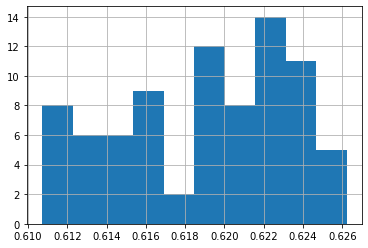

In [6]:
result.pct_correct.hist()

There is not much difference among results.

Keep in mind, this was just optimizing for accuracy in picking winners. In reality, there is also a point spread to consider. These ratings are not quite ready for Vegas, despite how accurate they are.

Still, what were our top parameters?

In [7]:
best = result.pct_correct.idxmax()
list(ParameterGrid(param_grid))[best]

{'home_adv': 0, 'k_val': 20, 'margin_div': 1, 'season_retain_weight': 0.5}

### Using the top performing parameters

Let's put them to use.

In [8]:
home_adv = list(ParameterGrid(param_grid))[best]['home_adv']
margin_div = list(ParameterGrid(param_grid))[best]['margin_div']
season_retain_weight = list(ParameterGrid(param_grid))[best]['season_retain_weight']
k_val = list(ParameterGrid(param_grid))[best]['k_val']

class Implementation:
    """
    A class that represents an implementation of the Elo Rating System
    """

    def __init__(self, base_rating=1500):
        """
        Runs at initialization of class object.
        @param base_rating - The rating a new player would have
        """
        self.base_rating = base_rating
        self.players = []

    def __getPlayerList(self):
        """
        Returns this implementation's player list.
        @return - the list of all player objects in the implementation.
        """
        return self.players

    def getPlayer(self, name):
        """
        Returns the player in the implementation with the given name.
        @param name - name of the player to return.
        @return - the player with the given name.
        """
        for player in self.players:
            if player.name == name:
                return player
        return None

    def contains(self, name):
        """
        Returns true if this object contains a player with the given name.
        Otherwise returns false.
        @param name - name to check for.
        """
        for player in self.players:
            if player.name == name:
                return True
        return False

    def addPlayer(self, name, rating=None):
        """
        Adds a new player to the implementation.
        @param name - The name to identify a specific player.
        @param rating - The player's rating.
        """
        if rating == None:
            rating = self.base_rating

        self.players.append(_Player(name=name,rating=rating))

    def removePlayer(self, name):
        """
        Adds a new player to the implementation.
        @param name - The name to identify a specific player.
        """
        self.__getPlayerList().remove(self.getPlayer(name))


    def recordMatch(self, name1, name2, winner=None, draw=False, margin=None):
        """
        Should be called after a game is played.
        @param name1 - name of the first player.
        @param name2 - name of the second player.
        """
        player1 = self.getPlayer(name1)
        player2 = self.getPlayer(name2)

        expected1 = player1.compareRating(player2, home = True)
        expected2 = player2.compareRating(player1, home = False)

        k = k_val

        rating1 = player1.rating
        rating2 = player2.rating

        if draw:
            score1 = 0.5
            score2 = 0.5
        elif winner == name1:
            score1 = 1.0
            score2 = 0.0
        elif winner == name2:
            score1 = 0.0
            score2 = 1.0
        else:
            raise InputError('One of the names must be the winner or draw must be True')

        if draw:
            newRating1 = rating1 + k * (score1 - expected1)
            newRating2 = rating2 + k * (score2 - expected2)
        else:
            newRating1 = rating1 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score1 - expected1)
            newRating2 = rating2 + k * ((np.log((margin/margin_div) + np.exp(1)))) * (score2 - expected2)


        if newRating1 < 0:
            newRating1 = 0
            newRating2 = rating2 - rating1

        elif newRating2 < 0:
            newRating2 = 0
            newRating1 = rating1 - rating2

        player1.rating = newRating1
        player2.rating = newRating2

    def getPlayerRating(self, name):
        """
        Returns the rating of the player with the given name.
        @param name - name of the player.
        @return - the rating of the player with the given name.
        """
        player = self.getPlayer(name)
        return player.rating

    def getRatingList(self):
        """
        Returns a list of tuples in the form of ({name},{rating})
        @return - the list of tuples
        """
        lst = []
        for player in self.__getPlayerList():
            lst.append((player.name,player.rating))
        return lst

class _Player:
    """
    A class to represent a player in the Elo Rating System
    """

    def __init__(self, name, rating):
        """
        Runs at initialization of class object.
        @param name - TODO
        @param rating - TODO
        """
        self.name = name
        self.rating = rating

    def compareRating(self, opponent, home):
        """
        Compares the two ratings of the this player and the opponent.
        @param opponent - the player to compare against.
        @returns - The expected score between the two players.
        """
        if home == True:
            return ( 1+10**( ( opponent.rating-self.rating-home_adv )/400.0 ) ) ** -1
        else:
            return ( 1+10**( ( opponent.rating-self.rating+home_adv )/400.0 ) ) ** -1

games_count_df = pd.DataFrame(columns=games_df.home.unique())
games_count_df.loc[0] = [0 for col in games_count_df.columns]

game_elo_df = pd.DataFrame(columns=games_df.home.unique())

uni = Implementation()


for team in games_df.home.unique():
    uni.addPlayer(name = team)

total = 0
correct = 0
for season in games_df.year.unique():
    for week in games_df.week.unique():
        for ind in games_df[(games_df.year==season) & (games_df.week==week)].index:
            home = games_df.loc[ind, 'home']
            away = games_df.loc[ind, 'away']

            home_elo = uni.getPlayerRating(home)
            away_elo = uni.getPlayerRating(away)
            if home_elo > away_elo:
                pred = home
            else:
                pred = away

            games_count_df.loc[0, home] = games_count_df.loc[0, home]+1
            games_count_df.loc[0, away] = games_count_df.loc[0, away]+1

            margin = games_df.loc[ind, 'home_pts'] - games_df.loc[ind, 'away_pts']

            if margin > 0:
                winner = home
            elif margin < 0:
                winner = away
                margin *= -1
            else:
                winner = 'tie'

            if winner == 'tie':
                uni.recordMatch(home, away, draw=True)
            else:
                uni.recordMatch(home, away, winner, margin=margin)

            total += 1
            if pred == winner:
                correct += 1

            game_elo_df.loc[games_count_df.loc[0, home], home] = uni.getPlayerRating(home)
            game_elo_df.loc[games_count_df.loc[0, away], away] = uni.getPlayerRating(away)

    games_count_df.loc[0] = [games_count_df.max().max() for col in games_count_df.columns]

    for team in games_df.home.unique():
            uni.getPlayer(team).rating = (season_retain_weight * uni.getPlayerRating(team)) +\
                ((1-season_retain_weight) * 1500)

### Visualizing the results

What does the history of your favorite team look like?

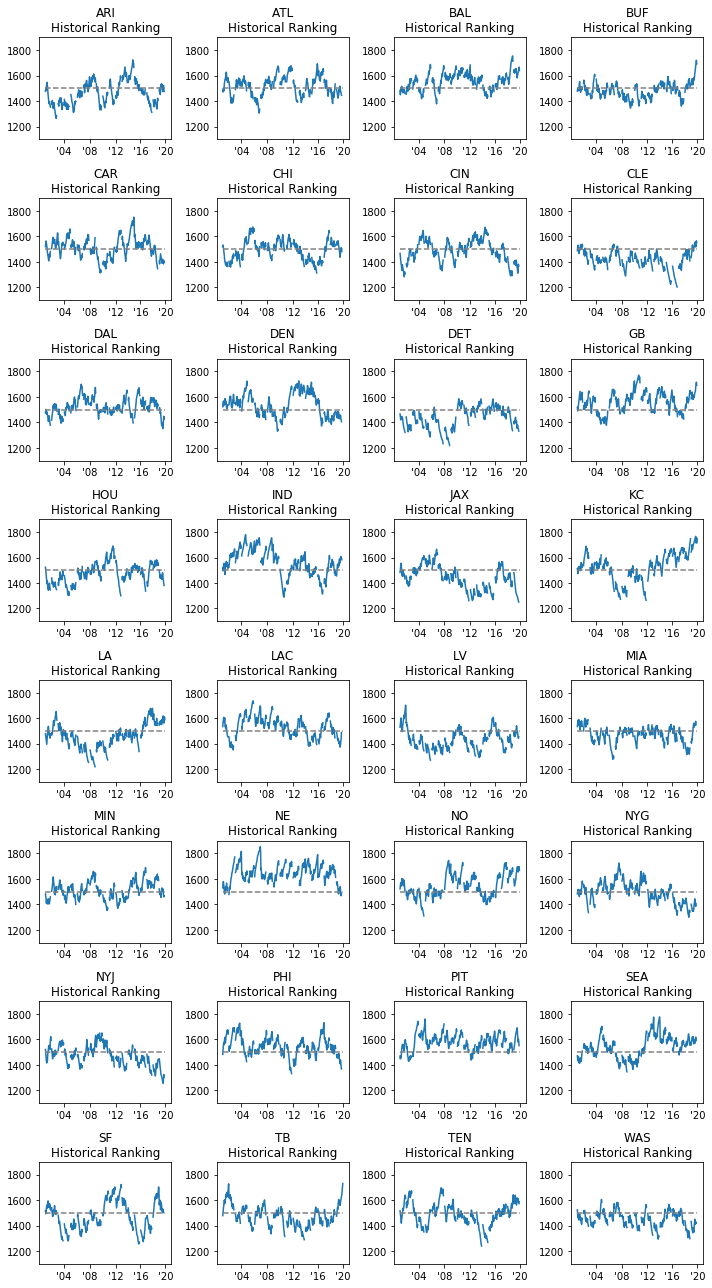

In [9]:
ticks = [58.0,137.0,216.0,292.0,369.0]

fig, axs = plt.subplots(8,4)
fig.set_size_inches(10, 18)

j = -1
for i in range(len(game_elo_df.columns)):
    if i%4 == 0:
        j+=1
    game_elo_df[game_elo_df.columns.sort_values()[i]].plot(ax = axs[j,i%4])
    axs[j, i%4].set_title(game_elo_df.columns.sort_values()[i] + '\nHistorical Ranking')
    axs[j, i%4].set_ylim(1100,1900)
    axs[j, i%4].xaxis.set_ticks(ticks)
    axs[j, i%4].set_xticklabels(["'04", "'08", "'12", "'16", "'20"])
    axs[j, i%4].plot(game_elo_df.index, [1500 for i in game_elo_df.index],'--', color='#808080')
plt.tight_layout()
plt.savefig('nfl_elo_vis_top.png')